# import

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import random
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

# Data 준비

In [2]:
train_files = glob('C:/Users/hogbal/Desktop/RUP/preprocessing/input/train/*.png')
val_files = glob('C:/Users/hogbal/Desktop/RUP/preprocessing/input/val/*.png')
len(train_files), len(val_files)

(1912, 215)

In [3]:
class2idx = {
    'pet':0,
    'pp':1,
    'ps':2
}
class2idx['pet']

0

# TFRecord File 만들기

In [4]:
IMG_SIZE = 640

In [5]:
tfr_train_dir = 'C:/Users/hogbal/Desktop/RUP/preprocessing/output/train.tfrecord'
tfr_val_dir = 'C:/Users/hogbal/Desktop/RUP/preprocessing/output/val.tfrecord'

In [6]:
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [7]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [8]:
n_train = 0

for train_path in tqdm(train_files):
    image = Image.open(train_path)
    bimage = image.tobytes()

    file_name = os.path.basename(train_path)
    file_name = os.path.splitext(file_name)[0]
    class_name = re.sub('\d+', '', file_name)
    class_num = class2idx[class_name]

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(class_num)
    }))
    writer_train.write(example.SerializeToString())
    n_train += 1

writer_train.close()
print(n_train)

100%|█████████████████████████████████████████████████████████████████████████████| 1912/1912 [00:17<00:00, 112.22it/s]


1912


In [9]:
n_val = 0

for val_path in tqdm(val_files):
    image = Image.open(val_path)
    bimage = image.tobytes()

    file_name = os.path.basename(val_path)
    file_name = os.path.splitext(file_name)[0]
    class_name = re.sub('\d+', '', file_name)
    class_num = class2idx[class_name]

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(class_num)
    }))
    writer_val.write(example.SerializeToString())
    n_val += 1

writer_val.close()
print(n_val)

100%|███████████████████████████████████████████████████████████████████████████████| 215/215 [00:01<00:00, 115.42it/s]


215


# test

In [10]:
## Hyper Parameters
N_CLASS = 3
N_EPOCHS = 50
N_BATCH = 40
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 640
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [11]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)
    label = tf.one_hot(label, N_CLASS)

    return image, label

In [12]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [13]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

C:\Users\hogbal\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


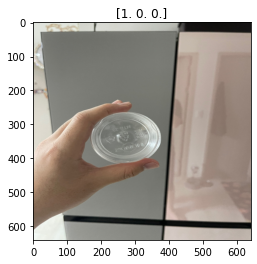

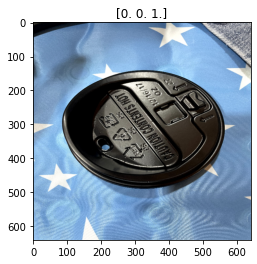

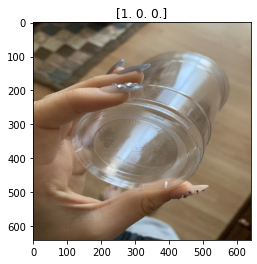

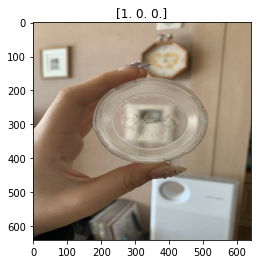

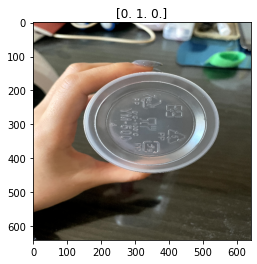

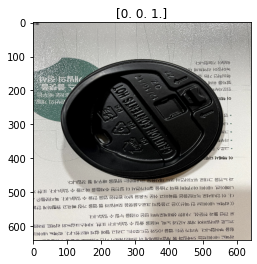

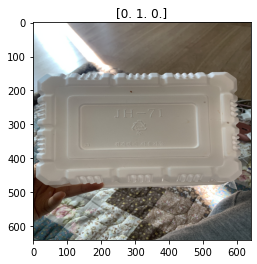

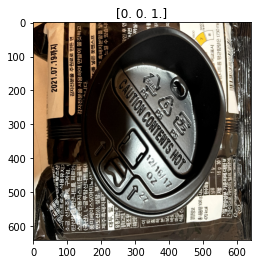

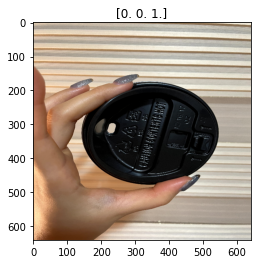

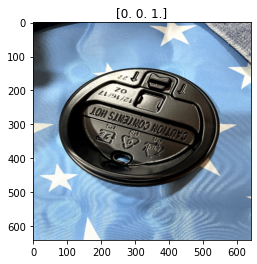

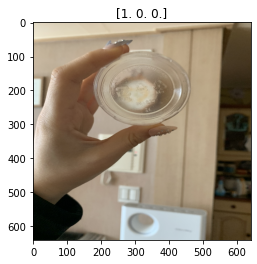

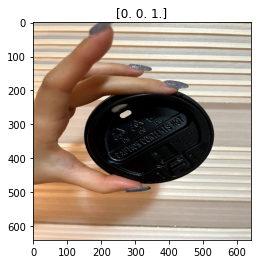

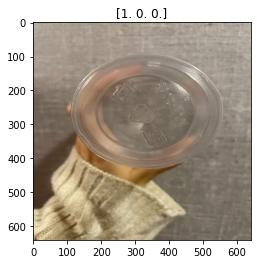

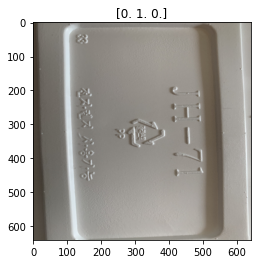

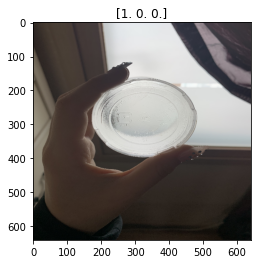

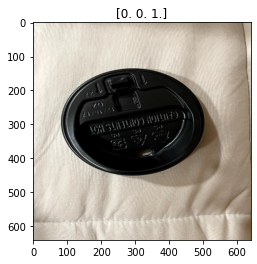

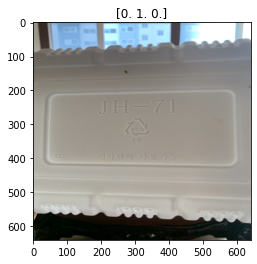

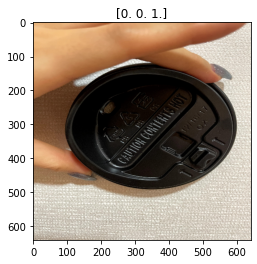

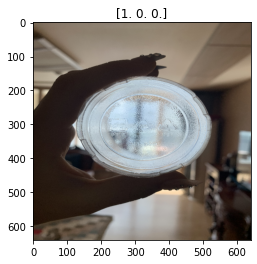

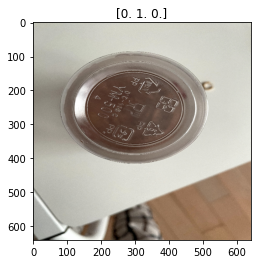

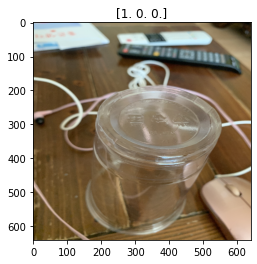

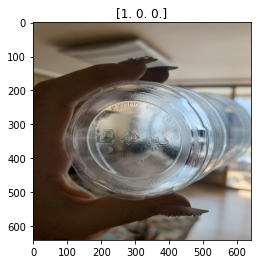

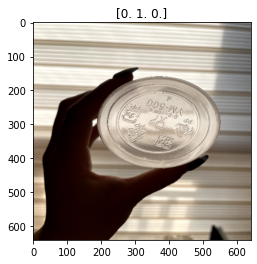

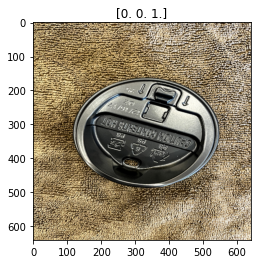

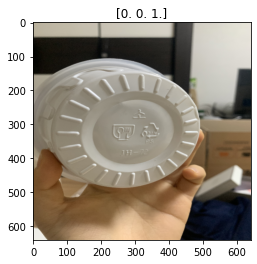

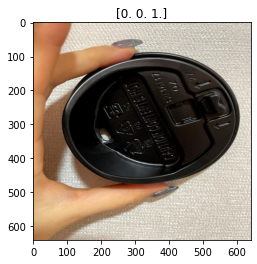

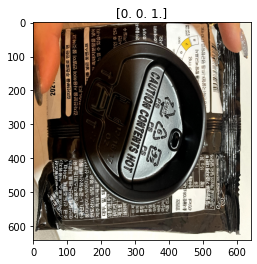

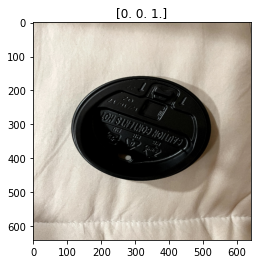

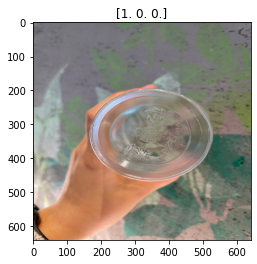

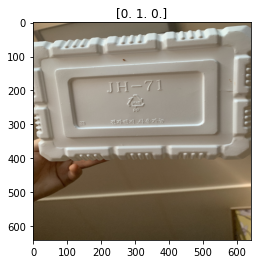

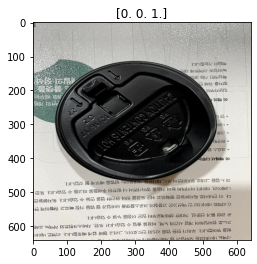

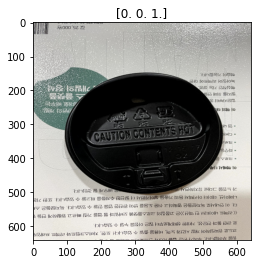

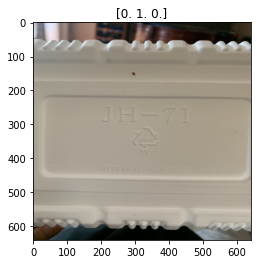

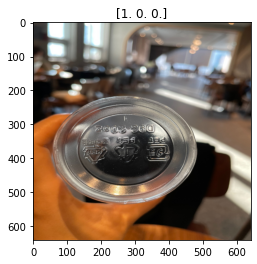

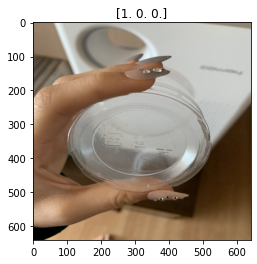

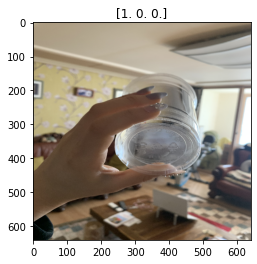

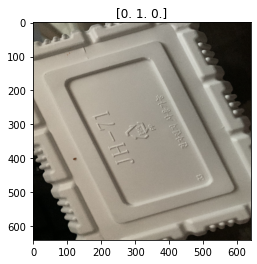

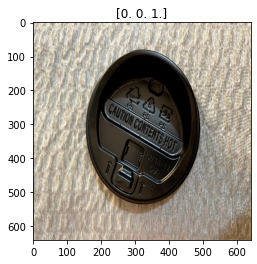

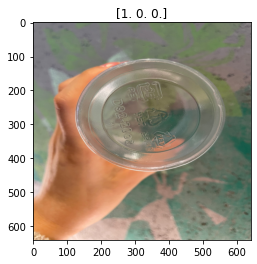

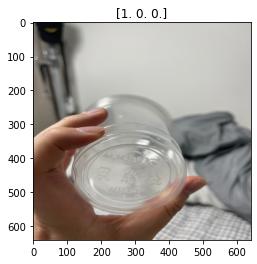

In [14]:
for image, label in train_dataset.take(1):
  for i in range(N_BATCH):
    plt.title(label[i].numpy())
    plt.imshow(image[i])
    plt.show()